In [1]:
from pythtb import * # import TB model class
import numpy as np

import matplotlib.pyplot as plt

import ase
import ase.io
import ase.neighborlist
import ase.visualize.plot

In [2]:
len_of_agnr = 16
U_param = 19

In [3]:
file_name = "./xyz_files/7_AGNR_len_{}.xyz".format(len_of_agnr)
geom = ase.io.read(file_name)
lat = [
    [1.0,0.0],
    [0.0,1.0]
]
geom.center(about=0.0)
orb = []

for at in geom:
    orb.append(at.position[:2])
    
max_coord = np.max(orb)+1

In [4]:
p_results_file = "./calculations/processed_ev_7agnr{}_U{}.txt".format(len_of_agnr, U_param)
p_f = open(p_results_file, "r")

p_num_lines = sum(1 for line in open(p_results_file, "r"))
p_evals = np.zeros(p_num_lines, dtype=float)
p_counter = 0

for p_line in p_f:
    p_spin = p_line[:2]
    p_line = p_line[3:]

    p_splitted_line = p_line.split(' ')

    p_evals[p_counter] = np.float64(p_splitted_line[0])
    p_counter = p_counter + 1
    
chemical_potential = p_evals[int(p_num_lines/2)] - p_evals[int(p_num_lines/2-1)]
print(chemical_potential)

0.9667599999999998


In [5]:
results_file = "./calculations/processed_ev_7agnr{}_U{}.txt".format(len_of_agnr, U_param)
f = open(results_file, "r")

num_lines = sum(1 for line in open(results_file, "r"))
print(num_lines)
num_values_evecs = int(num_lines / 2)

448


In [6]:
evals = np.zeros(num_lines, dtype=float)
evecs_shape = (num_lines, num_values_evecs)
evecs = np.zeros(evecs_shape, dtype=complex)

total_spin_up = np.zeros(int(num_lines/2), dtype=float)
total_spin_down = np.zeros(int(num_lines/2), dtype=float)
up_spins = 0
down_spins = 0

evals_up = np.full(num_lines, -100, dtype=float)
evals_down = np.full(num_lines, -100, dtype=float)
counter_up = 0
counter_down = 0
    
counter = 0
word_count = 0

In [7]:
for line in f:
    spin = line[:2]
    line = line[3:]

    splitted_line = line.split(' ')

    evals[counter] = np.float64(splitted_line[0])
    
    if(spin == 'su'):
        evals_up[counter_up] = evals[counter] - chemical_potential
        counter_up = counter_up + 1
    if(spin == 'sd'):
        evals_down[counter_down] = evals[counter] - chemical_potential
        counter_down = counter_down + 1
    
    splitted_line.pop(0)
    
    x = ''
    y = ''
    y_turn = False
    
    for j in range(len(splitted_line)):    
        for i in splitted_line[j]:
            if(i == '(' or i == ' '):
                continue
            if(i != ',' and y_turn == False):
                x += i
            elif(i == ','):
                y_turn = True
                continue
            elif(i != ')'):
                y += i
            else:
                evecs[counter, word_count] = complex(float(x), float(y))
                x = ''
                y = ''
                word_count = word_count + 1
                y_turn = False


    word_count = 0
    counter = counter + 1
    
    if(spin == 'su'):
        if(chemical_potential > evals[counter-1]):
            up_spins = up_spins + 1
            total_spin_up = np.add(total_spin_up, np.square(evecs[counter-1]))
    if(spin == 'sd'):
        if(chemical_potential > evals[counter-1]):
            down_spins = down_spins + 1
            total_spin_down = np.add(total_spin_down, np.square(evecs[counter-1]))

    if counter == num_lines:
        break
        
        
print("total up spins: " + str(up_spins))
print("total down spins: " + str(down_spins))
print(total_spin_up)
print(total_spin_down)
spin_difference = ((total_spin_up - total_spin_down))
print(np.shape(spin_difference))
print(spin_difference)

print("evals spin up: " + str(evals_up))
print("evals spin down: " + str(evals_down))

total up spins: 102
total down spins: 102
[0.35410324+0.j 0.28180237+0.j 0.35410244+0.j 0.54795006+0.j
 0.37418814+0.j 0.5512185 +0.j 0.44648708+0.j 0.55121863+0.j
 0.4464873 +0.j 0.5479506 +0.j 0.37418714+0.j 0.50479134+0.j
 0.48070697+0.j 0.5047913 +0.j 0.42603455+0.j 0.43502431+0.j
 0.42603444+0.j 0.46395565+0.j 0.41726944+0.j 0.50378858+0.j
 0.46298988+0.j 0.50378822+0.j 0.4629899 +0.j 0.46395425+0.j
 0.41727001+0.j 0.46055683+0.j 0.44995688+0.j 0.46055709+0.j
 0.42747622+0.j 0.43007342+0.j 0.42747631+0.j 0.45561006+0.j
 0.42124199+0.j 0.48682199+0.j 0.47018612+0.j 0.48682143+0.j
 0.47018529+0.j 0.45561007+0.j 0.4212421 +0.j 0.45053137+0.j
 0.45831782+0.j 0.45053188+0.j 0.44330431+0.j 0.44293365+0.j
 0.44330411+0.j 0.44323091+0.j 0.44265653+0.j 0.48025606+0.j
 0.47887172+0.j 0.48025604+0.j 0.47887187+0.j 0.44323087+0.j
 0.44265674+0.j 0.44438127+0.j 0.443444  +0.j 0.44438183+0.j
 0.45092007+0.j 0.44581965+0.j 0.45092012+0.j 0.44266123+0.j
 0.43773098+0.j 0.48105594+0.j 0.47972585+0

In [8]:
ed = num_lines//2
print(num_lines, ed)
homo = ed-1

448 224


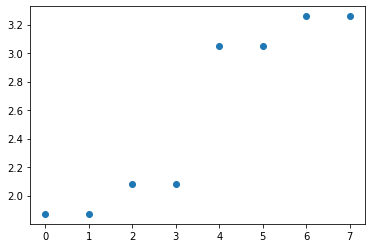

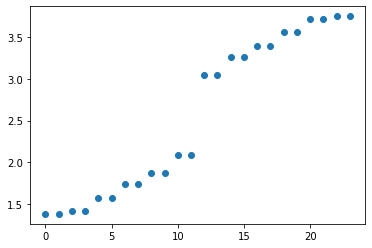

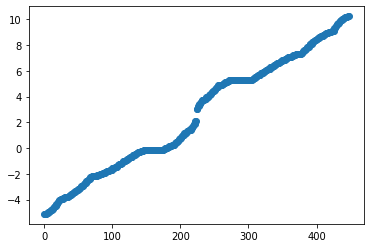

-5.11636
-5.11636
-5.09262
-5.09262
-5.0525
-5.0525
-4.99631
-4.9963
-4.92426
-4.92426
-4.8366
-4.8366
-4.73363
-4.73363
-4.61566
-4.61566
-4.4831
-4.4831
-4.33639
-4.33639
-4.17604
-4.17604
-4.00264
-4.00264
-3.94643
-3.94643
-3.92504
-3.92504
-3.88887
-3.88887
-3.83803
-3.83803
-3.81685
-3.81685
-3.7727
-3.7727
-3.69308
-3.69308


In [9]:
plt.plot(evals[ed-4:ed+4], 'o')
plt.show()

plt.plot(evals[ed-12:ed+12], 'o')
plt.show()

plt.plot(evals[:], 'o')
plt.show()

for ev in evals[0:38]:
    print(ev)

In [10]:
def visualize_backbone(ax, atoms):
    i_arr, j_arr = ase.neighborlist.neighbor_list('ij', atoms, 1.8)
    for i, j in zip(i_arr, j_arr):
        if i < j:
            p1 = atoms.positions[i]
            p2 = atoms.positions[j]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k-', linewidth=2.0, solid_capstyle='round')
            
def visualize_evec(ax, atoms, evec):
    for at, e in zip(atoms, evec):
        p = at.position
        mod = np.abs(e)
        phase = np.angle(e)/np.pi
        col = (1.0-phase, 0.0, phase)
        circ = plt.Circle(p[:2], np.cbrt(mod), color=col, zorder=10)
        ax.add_artist(circ)

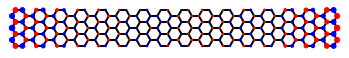

In [11]:
fig=plt.figure(figsize=(6,6))
ax = plt.gca()
ax.set_aspect('equal')
visualize_backbone(ax, geom)
visualize_evec(ax, geom, spin_difference)
plt.axis('off')


#plt.xlim([-1, np.min([max_coord, 16.5])])

plt.xlim([-1, max_coord])
plt.ylim([-1, 8])

path = "./U_to_t_{}".format(U_param)
fig_name = path + "/spin_diff_7agnr{}_U{}.pdf".format(len_of_agnr, U_param)
plt.savefig(fig_name, dpi=1000, bbox_inches='tight')

In [12]:
"""
for ind in range(ed-2,ed+2):
    fig=plt.figure(figsize=(6,6))
    ax = plt.gca()
    ax.set_aspect('equal')
    visualize_backbone(ax, geom)
    visualize_evec(ax, geom, evecs[ind,:])
    plt.axis('off')
    xmin = np.min(geom.positions[:, 0])-0.7
    xmax = np.max(geom.positions[:, 0])+0.7
    ymin = np.min(geom.positions[:, 1])+1.0
    ymax = np.max(geom.positions[:, 1])+1.0
    plt.xlim([xmin, xmax])
    plt.text(xmin+1.0, ymin-2.6, "E = %.2f eV" % evals[ind], fontsize=20)
    #plt.savefig("./figures/figures_clar/orb_%d_%d.png" % (ind, ind-homo), dpi=300, bbox_inches='tight')
"""

'\nfor ind in range(ed-2,ed+2):\n    fig=plt.figure(figsize=(6,6))\n    ax = plt.gca()\n    ax.set_aspect(\'equal\')\n    visualize_backbone(ax, geom)\n    visualize_evec(ax, geom, evecs[ind,:])\n    plt.axis(\'off\')\n    xmin = np.min(geom.positions[:, 0])-0.7\n    xmax = np.max(geom.positions[:, 0])+0.7\n    ymin = np.min(geom.positions[:, 1])+1.0\n    ymax = np.max(geom.positions[:, 1])+1.0\n    plt.xlim([xmin, xmax])\n    plt.text(xmin+1.0, ymin-2.6, "E = %.2f eV" % evals[ind], fontsize=20)\n    #plt.savefig("./figures/figures_clar/orb_%d_%d.png" % (ind, ind-homo), dpi=300, bbox_inches=\'tight\')\n'

In [13]:
"""
#chemical_potential = 0.875
past_ev_up = -100
past_ev_down = -100


fig = plt.figure(figsize=(6, 20))
plt.subplot(121)
ax = plt.gca()
for ev in evals_down:
    if ev == -100:
        continue
    
    col = 'b'
    if ev < 0.0:
        col = 'r'
        #print("Down spin ev: " + str(ev))
    if(ev > past_ev_down + 0.001):
        plt.plot([0.55, 0.9], [ev, ev], '-', color=col, lw=3.0, solid_capstyle='round')
    else:
        plt.plot([0.1, 0.45], [ev, ev], '-', color=col, lw=3.0, solid_capstyle='round')
    past_ev_down = ev


ax.get_xaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlim(0.0, 1.0)
#plt.ylim(-1.8, 1.8)
plt.ylabel("E/t", rotation=0, fontsize=15, labelpad=20)

###

plt.subplot(122)
ax = plt.gca()
for ev in evals_up:
    if ev == -100:
        continue
        
    col = 'b'
    if ev < 0.0:
        col = 'r'
        #print("Up spin ev: " + str(ev))
    if(ev > past_ev_up + 0.003):
        plt.plot([0.1, 0.45], [ev, ev], '-', color=col, lw=3.0, solid_capstyle='round')
    else:
        plt.plot([0.55, 0.9], [ev, ev], '-', color=col, lw=3.0, solid_capstyle='round')
    past_ev_up = ev
    
ax.get_xaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlim(0.0, 1.0)
#plt.ylim(-1.8, 1.8)

plt.savefig("./figures/figures_clars_tb/spin_occ.png", dpi=500, bbox_inches='tight')
plt.show()
"""

'\n#chemical_potential = 0.875\npast_ev_up = -100\npast_ev_down = -100\n\n\nfig = plt.figure(figsize=(6, 20))\nplt.subplot(121)\nax = plt.gca()\nfor ev in evals_down:\n    if ev == -100:\n        continue\n    \n    col = \'b\'\n    if ev < 0.0:\n        col = \'r\'\n        #print("Down spin ev: " + str(ev))\n    if(ev > past_ev_down + 0.001):\n        plt.plot([0.55, 0.9], [ev, ev], \'-\', color=col, lw=3.0, solid_capstyle=\'round\')\n    else:\n        plt.plot([0.1, 0.45], [ev, ev], \'-\', color=col, lw=3.0, solid_capstyle=\'round\')\n    past_ev_down = ev\n\n\nax.get_xaxis().set_visible(False)\nax.spines[\'right\'].set_visible(False)\nax.spines[\'top\'].set_visible(False)\nax.spines[\'bottom\'].set_visible(False)\nplt.xlim(0.0, 1.0)\n#plt.ylim(-1.8, 1.8)\nplt.ylabel("E/t", rotation=0, fontsize=15, labelpad=20)\n\n###\n\nplt.subplot(122)\nax = plt.gca()\nfor ev in evals_up:\n    if ev == -100:\n        continue\n        \n    col = \'b\'\n    if ev < 0.0:\n        col = \'r\'\n    

In [14]:
"""
past_ev = -100
last_loc = 0

fig = plt.figure(figsize=(12, 18))
ax = plt.gca()
for ev in evals[ed-ed:ed*2]:
    col = 'b'
    if ev < chemical_potential:
        col = 'r'
        
    if ev > past_ev + 0.003:
        last_loc = 0
    
    loc_x = 0.05 + last_loc * 0.25 
    loc_y = loc_x + 0.15
    
    if last_loc != 0:
        plt.plot([loc_x, loc_y], [ev, ev], '-', color=col, lw=3.0, solid_capstyle='round')
        last_loc = last_loc + 1
    else:
        plt.plot([0.05, 0.20], [ev, ev], '-', color=col, lw=3.0, solid_capstyle='round')
        last_loc = 1
    
    past_ev = ev
    
ax.get_xaxis().set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlim(0.0, 1.0)
plt.ylim(-3.0, 3.0)
plt.ylabel("Energy (eV)")
plt.savefig("./figures/figures_clars_tb/clars_goblet_spin_occ_single_channel.png", dpi=300, bbox_inches='tight')
"""

'\npast_ev = -100\nlast_loc = 0\n\nfig = plt.figure(figsize=(12, 18))\nax = plt.gca()\nfor ev in evals[ed-ed:ed*2]:\n    col = \'b\'\n    if ev < chemical_potential:\n        col = \'r\'\n        \n    if ev > past_ev + 0.003:\n        last_loc = 0\n    \n    loc_x = 0.05 + last_loc * 0.25 \n    loc_y = loc_x + 0.15\n    \n    if last_loc != 0:\n        plt.plot([loc_x, loc_y], [ev, ev], \'-\', color=col, lw=3.0, solid_capstyle=\'round\')\n        last_loc = last_loc + 1\n    else:\n        plt.plot([0.05, 0.20], [ev, ev], \'-\', color=col, lw=3.0, solid_capstyle=\'round\')\n        last_loc = 1\n    \n    past_ev = ev\n    \nax.get_xaxis().set_visible(False)\nax.spines[\'right\'].set_visible(False)\nax.spines[\'top\'].set_visible(False)\nax.spines[\'bottom\'].set_visible(False)\nplt.xlim(0.0, 1.0)\nplt.ylim(-3.0, 3.0)\nplt.ylabel("Energy (eV)")\nplt.savefig("./figures/figures_clars_tb/clars_goblet_spin_occ_single_channel.png", dpi=300, bbox_inches=\'tight\')\n'